In [1]:
import glob
import os
from collections import Counter
from itertools import product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *

import seaborn as sb
sb.set(font_scale=.6)
import matplotlib.pyplot as plt
plt.style.use('grayscale')
sb.set_style("white")
sb.set_palette("Greys_r")

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = 'Greys_r'

from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']
from IPython.display import display

## Loading and preprocessing

We create a directory for saving the figures if required:

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

We load the spreadsheet which holds the tabular overview of the annotated intertexts:

In [3]:
intertexts = pd.read_excel('../data/intertexts.xlsx')
print(len(intertexts), 'annotated in total')
intertexts.sample(5)

229 annotated in total


,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
97,mor-mou-16,Moriaen,Hie deetse bat achtergaen.,Riddere metter mouwen,Ende dadense also achtergaen.,1,Van der Stempel 1930,Editions have achterstaen. Might not be a link.
145,lan-ele-21,Lantsloot van der Haghedochte,Mar ic segghe v dat ic v rade Omme te bescuwene meere scade:,Moriaen,oft gi werken wilt bi rade Ende scuwen wilt vwe scade.,2,"Heeroma 1973b, Moriaen (II)",NaN
8,mor-ele-9,Moriaen,God hi mach v wel gesterken.,Karel ende Elegast,Nv so moetti - God - mi gestercken:,1,"Heeroma 1973a, Moriaen (I)",NaN
84,mor-mou-4,Moriaen,Doe hi achters van u sciet,Riddere metter mouwen,Doe hi achters van hem sciet,1,Van der Stempel 1917,Double case
25,mor-ele-26,Moriaen,En ontfinc noit vlecge no scard.,Karel ende Elegast,Ende ontfingen scarde ende vlegghen:,1,"Heeroma 1973a, Moriaen (I)",NaN


Each row documents one attestation of an intertext in a pair of texts, with for every instance:
- an `ID`, which is not unique, becomes the same intertext can be attested multiple times (i.e. for different document pairs);
- the title of the `source` text and the `target` text (one of the four texts considered: *Lantsloot van der Hagedochte*, *Moriaen*, *Riddere metter mouwen*, *Karel ende Elegast*). Note that the direction of the intertext (cf. source vs target) is not material in what follows;
- the actual passage in the source and target text (`src-passage` and `trg-passage`) quoted in the referenced publication; in the XML data (see "data/xml") the suggested annotation has been encoded at the level of entire verse line;
- the approximate length of the match expressed in the number of verse lines involved;
- a bibliographical reference for the intertext (`biblio`);
- potentially, some (informal) `remarks`, which can be safely disregarded.

While this spreadsheet holds a useful overview, the intertexts have also been manually encoded in the XML files in the `data/xml` directory in this repository, using an `intertext` attribute at the verse level that holds the corresponding `ID` of the row in the spreadsheet. For instance, in the *Elegast*:

```xml
  <l n="13" tokens="Crone draghen ende houden hof" intertext="mor-ele-2">
    ...
  </l>
  <l n="14" tokens="Om te meerderen sinen lof" intertext="mor-ele-2">
    ...
  </l>
```

We can plot the length distribution (in verse lines) of the intertexts:

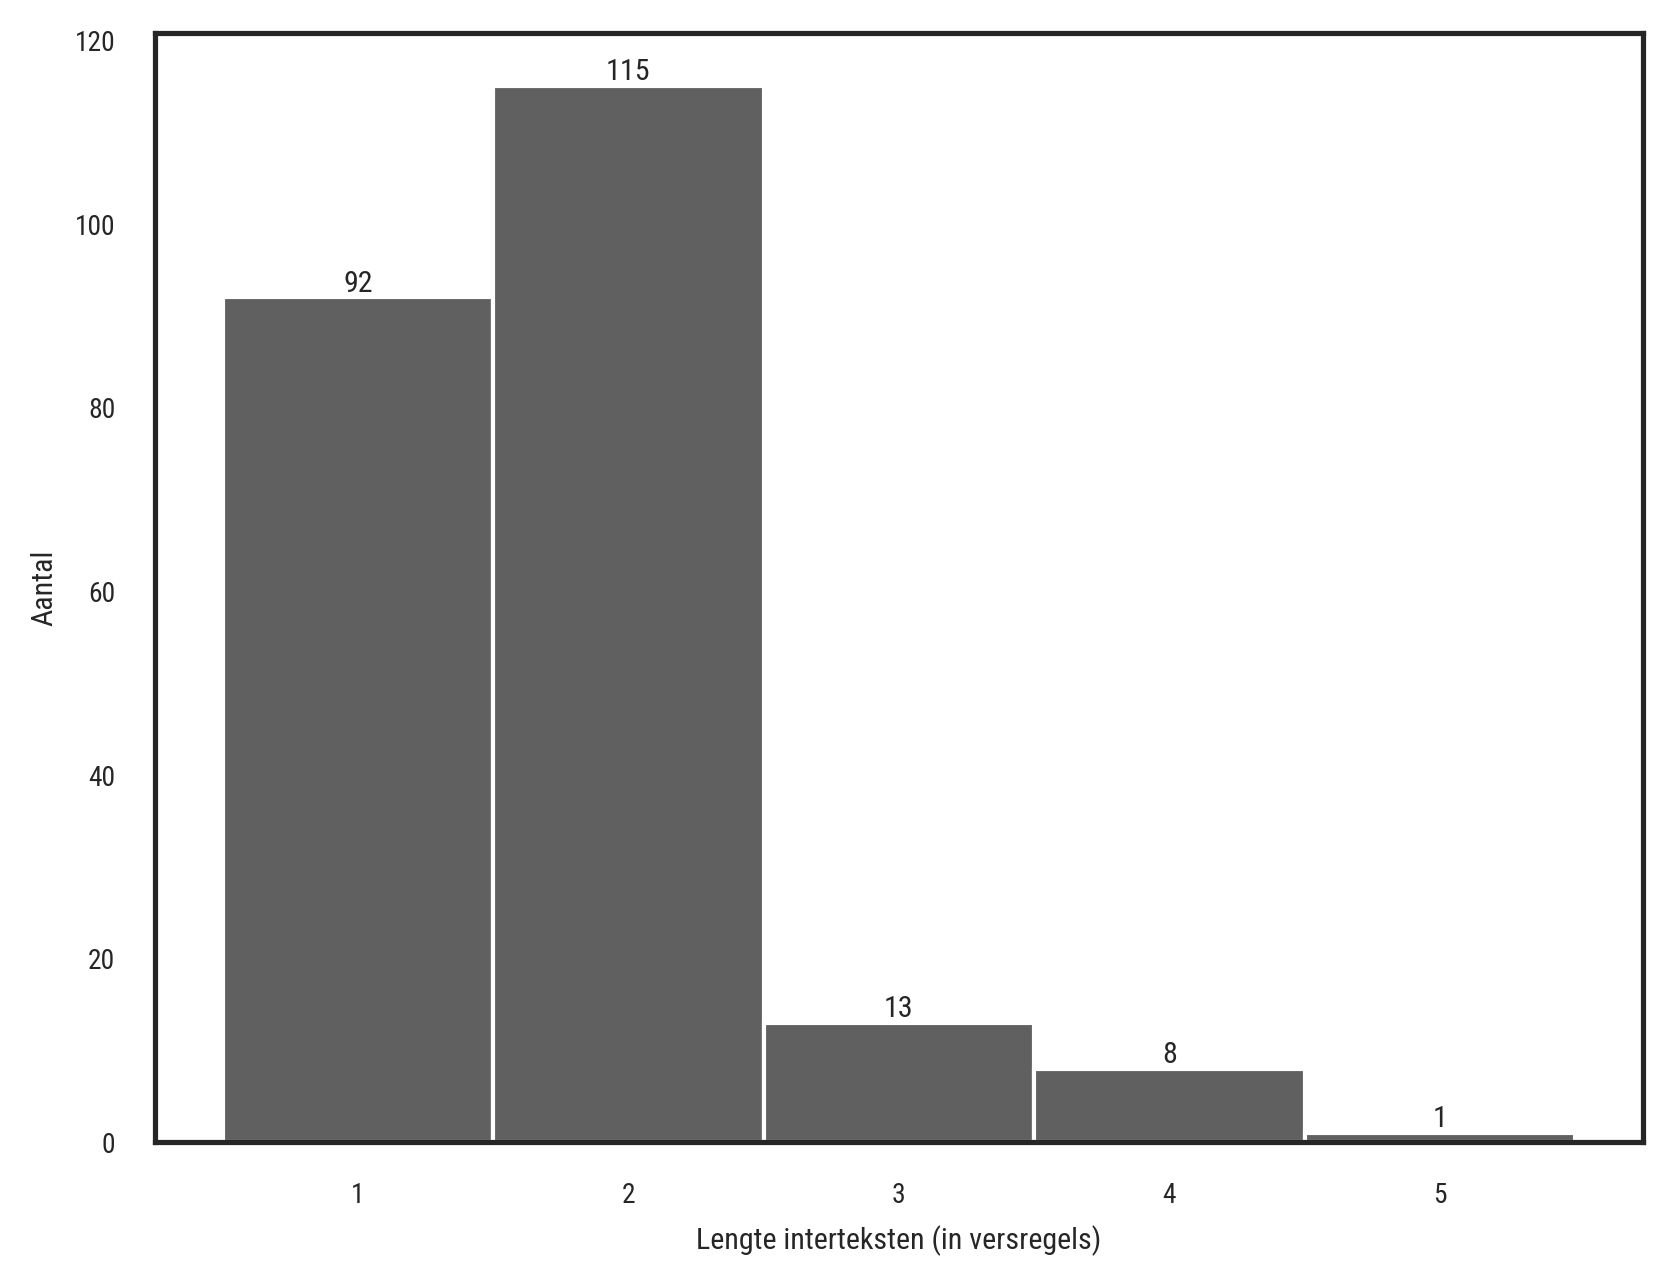

In [4]:
ax = sb.histplot(data=intertexts, x='verse-length', discrete=True)

heights = [p.get_height() for p in ax.patches]

for i, height in enumerate(heights):
    x_pos = ax.patches[i].get_x() + ax.patches[i].get_width()/2
    
    ax.text(x_pos, height, 
            str(int(height)),
            ha='center',
            va='bottom')

plt.xlabel('Lengte interteksten (in versregels)')
plt.ylabel('Aantal')
plt.savefig(f'{fig_dir}/Afb3.jpg', dpi=300)

The annotated intertexts are comparatively short (1-2 lines).

Below, we plot the number of absolute intertexts available across all text pairs (which are far from symmetric):

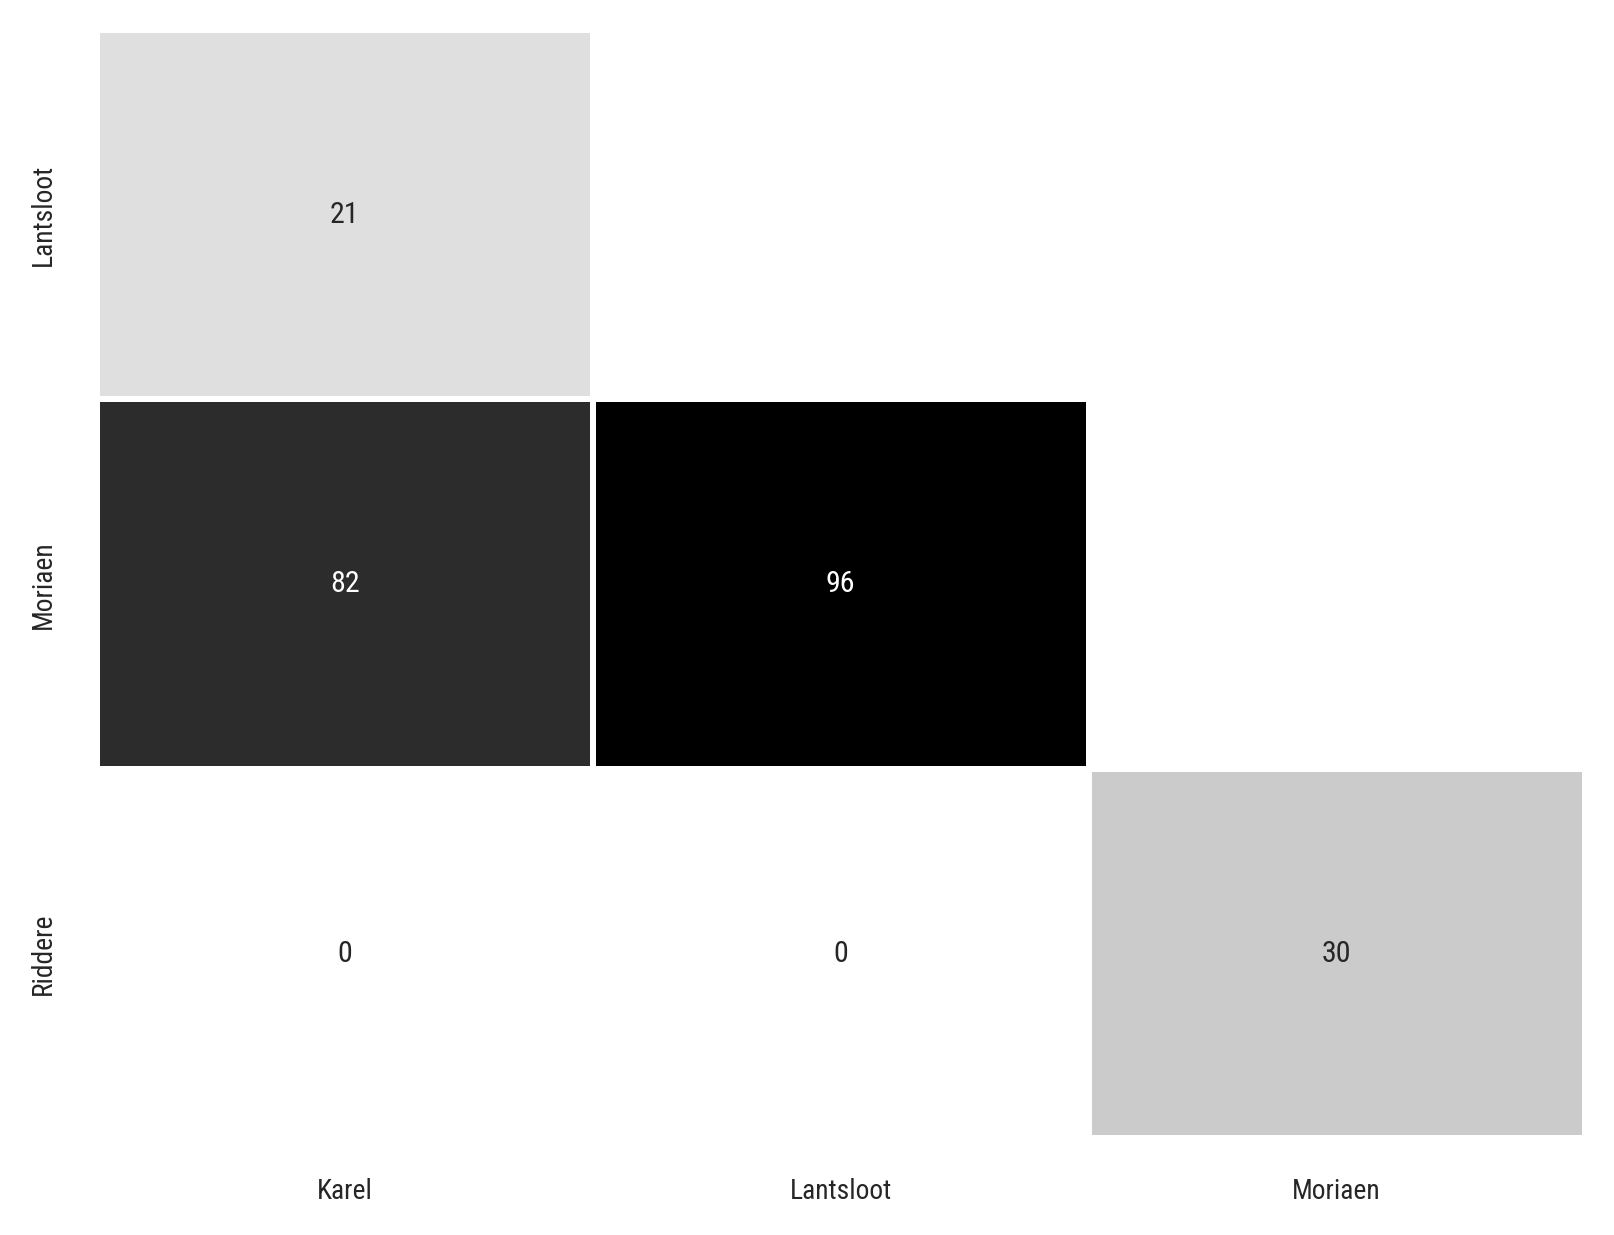

In [5]:
titles = sorted(set(intertexts['source'].tolist() + intertexts['target'].tolist()))
counts = np.zeros((len(titles), len(titles)))
for _, row in intertexts.iterrows():
    counts[titles.index(row['source']), titles.index(row['target'])] += 1
    counts[titles.index(row['target']), titles.index(row['source'])] += 1
np.fill_diagonal(counts, np.nan)
counts[np.triu_indices(4)] = np.nan
titles = [t.split()[0] for t in titles]
counts = pd.DataFrame(counts, columns=titles, index=titles)
counts = counts.iloc[1:, :-1]
ax = sb.heatmap(counts, annot=True, cmap='Greys', cbar=False, linewidths=1, linecolor='white')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.savefig(f'{fig_dir}/Afb2.jpg', dpi=300);

#### Load metadata

We now load the metadata at the level of the XML files:

In [6]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,provenance,date_range,genre,subgenre,exclude
241,tien_plaghen,Tien plaghen ende die tien ghebode,NaN,cdrom-mnl,1390-1410,Epiek,Didactiek,NaN
95,roman_van_jonathas_ende_rosafiere_fragm_g,Jonathas ende Rosafiere,NaN,cdrom-mnl,1495-1515,Epiek,Ridder,NaN
223,spiegel_historiael__2_fragm_d,Spiegel historiael (P2),Philip Utenbroeke,cdrom-mnl,1350-1400,Epiek,Historiografie,NaN
263,van_ons_heren_wonden,Van ons heren wonden,NaN,cdrom-mnl,1400-1450,Lyriek,NaN,NaN
37,collectief_lunarium_ii,Collectief lunarium II,NaN,cdrom-mnl,1434-1436,Epiek,Didactiek,NaN
150,ongeidentificeerd_3,Ongeïdentificeerd (3),NaN,cdrom-mnl,1340-1360,Epiek,Karel,NaN
12,beerte_metten_breden_voeten,Beerte metten breden voeten,NaN,cdrom-mnl,1375-1425,Epiek,Karel,NaN
107,roman_van_limborch,Limborch,NaN,cdrom-mnl,1340-1360,Epiek,Ridder,NaN
35,collectief_lunarium_iii,Collectief lunarium III,NaN,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
11,bediedenisse_van_der_missen,Bediedenisse van der missen,NaN,cdrom-mnl,1340-1360,Epiek,Religie,NaN


The principles behind this metdata were previously discussed in this paper:

> Vandyck, Caroline & Kestemont, Mike, ‘Een auteur van formaat. Een attributie-onderzoek naar het oeuvre van de Limborch-dichter’. *Spiegel der letteren* 66:2 (2024), 111-167 [[doi]](https://doi.org/10.2143/SDL.66.2.3293546).

Apart from the genre labels (which are of course fuzzy and difficult to assign), the appendix to this paper also documents the interpolations that we remove from the texts below and our selection and merging of the textual witness, if multiple are available for a specific work (see the "exclude" column). We parse the XML files, using the following utility functions:

In [7]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                # special case where multiple intertexts 
                # are present in the sale verse group
                yield 'overlap'
            else:
                yield list(its.keys())[0]

def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
    
    # we remove (non-authorial) interpolations from the XMLs:
    # see the appendix to Vandyck & Kestemont (2024)
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('.//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

Some comments on this process:
- By default, we extract (overlapping) groups of two consecutive lines;
- When extracting intertexts, the iterator in `get_verse_groups` takes into account that, because of the sliding window approach, a verse group might yield an "overlap" if two intertexts are immediately adjacent;
- The lemmas for proper nouns are masked by replacing them with an 'n(prop)' symbol.

In [8]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(sorted(meta_df.groupby('title'))):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

 15%|█▌        | 32/207 [00:01<00:10, 16.79it/s]

- Could not load ../data/xml/denensage.xml


 86%|████████▋ | 179/207 [00:14<00:01, 16.31it/s]

- Could not load ../data/xml/trojeroman.xml
- Could not load ../data/xml/valckenborch.xml


100%|██████████| 207/207 [00:15<00:00, 13.80it/s]


We can now create a single, huge dataframe that has all the verse groups from the corpus, with a title, the original tokens, the lemmas (which we'll use for the matching) and the intertext which was annotated for them (if any):

In [9]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
# we ignore verse groups with ambiguous intertexts:
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())].sample(10)

,title,tokens,lemmas,intertext
339814,Karel ende Elegast,Ende sinen gherechten heere / Om te behouden sijn eere,en zijn gerecht heer / om te behouden zijn eer,mor-ele-68
339718,Karel ende Elegast,Als te nemen sijn leuen / Dat si hem goeden raet geuen,als te nemen zijn leven / dat zij hij goed raad geven,mor-ele-62
339031,Karel ende Elegast,Haer orssen sterc ende snel / Si waren beyde ghewapent wel,haar orssen sterk en snel / zij zijn beide gewapend wel,mor-ele-23
338776,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
338849,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
339750,Karel ende Elegast,Doen eggerics lieden quamen geuaren / In tconincs houe met scaren,doen n(prop) lieden komen varen / in de koning hof met schaar,mor-ele-65
339596,Karel ende Elegast,Ic sel weder keeren schiere / Doen bemaende die coninc diere,ik zullen weer keren schier / doen bemanen de koning duur,lan-ele-23
339748,Karel ende Elegast,Men dede ter poorten lx man / Gewapent ende halsberch an,men doen de te poort 60 man / wapenen en n(prop) aan,mor-ele-64
339332,Karel ende Elegast,Sulcke dinc als hem bedorste / Doe sat hi op al sonder vorste,zulk ding als hij bedorst / toen zitten hij op al zonder voorst,mor-ele-42
339328,Karel ende Elegast,Hi pensde in sinen moet / Dit is den ambocht goet,hij peinzen in zijn moed / dit zijn dat ambacht goed,mor-ele-41


Below, we'll assign special weight to the rhyme words in texts, which often seem to have served as a special cue or additional trigger for recognizing intertexts in the past. We'll achieve by adding an extra column to our dataframe, that has just the verse-final lemmas of the rhyme words:

In [10]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

df = add_rhyme_column(df)
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())].sample(10)

,title,tokens,lemmas,intertext,rhyme
339829,Karel ende Elegast,Mochte god doen sonde / So heeft hi sonde ghedaen,mogen god doen zonde / zo hebben hij zonde doen,lan-ele-65,zonde doen
339596,Karel ende Elegast,Ic sel weder keeren schiere / Doen bemaende die coninc diere,ik zullen weer keren schier / doen bemanen de koning duur,lan-ele-23,schier duur
338776,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11,gereden kleden
338774,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
339332,Karel ende Elegast,Sulcke dinc als hem bedorste / Doe sat hi op al sonder vorste,zulk ding als hij bedorst / toen zitten hij op al zonder voorst,mor-ele-42,bedorst voorst
339766,Karel ende Elegast,Ende waende gaen in die sale / Slootmen die poorten te male,en wanen gaan in de zaal / sluiten men de poort te maal,mor-ele-66,zaal maal
338695,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
339159,Karel ende Elegast,Karel vut minen lande / Ic salt segghen al ist scande,n(prop) uit mijn land / ik het zullen zeggen al het zijn schande,mor-ele-33,land schande
339338,Karel ende Elegast,Doen si quamen voor die veste / Die de scoonste was ende die beste,toen zij komen voor de vest / die de schoon zijn en de best,lan-ele-15,vest best
339107,Karel ende Elegast,In dien dat ghi mi maket vroet / Wat nootsaken dat v doet,in die dat gij ik maken vroed / wat noodzaak dat uw doen,mor-ele-31,vroed doen


#### Intermezzo: example TF-IDF

In the section below, we create the pedagogic example of the single example verse from *Karel ende Elegast*, illustrating the subsequent steps of:
- vectorization to a vector of relative frequencies
- rescaling the frequencies using the TF-IDF procedure
- vectorizing (only) the lemmas in rhyme position
- obtaining the final vector used for the retrieval system.

In [11]:
small = df[df['title'] == 'Karel ende Elegast'].iloc[[20]]
small

,title,tokens,lemmas,intertext,rhyme
338667,Karel ende Elegast,Wapent v ende vaert stelen / God die hiet mi v beuelen,wapenen gij en varen stelen / n(prop) die heten ik gij bevelen,None,stelen bevelen


In [12]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=5000, min_df=2,
                      tokenizer=tokenizer, norm='l1',
                      token_pattern=None, use_idf=False).fit(df['lemmas'])

In [13]:
small_vocab = set(' '.join(small['lemmas']).split())
print(small_vocab)
vocab = vec.get_feature_names_out()
small_vocab = sorted({v for v in small_vocab if v in vocab})
print(small_vocab)

{'varen', '/', 'heten', 'en', 'stelen', 'ik', 'wapenen', 'die', 'n(prop)', 'bevelen', 'gij'}
['bevelen', 'die', 'en', 'gij', 'heten', 'ik', 'n(prop)', 'stelen', 'varen', 'wapenen']


In [14]:
small_x = vec.transform(small['lemmas']).toarray()
features = list(vec.get_feature_names_out())
idxs = [features.index(l) for l in small_vocab]
rel_freq = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rel. freq.'])
rel_freq

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909


In [15]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      token_pattern=None,
                      tokenizer=tokenizer, use_idf=True).fit(df['lemmas'])
small_x = vec.transform(small['lemmas']).toarray()
features = list(vec.get_feature_names_out())
idxs = [features.index(l) for l in small_vocab]
tfidf = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['TF-IDF'])
tfidf

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
TF-IDF,0.401035,0.161024,0.114834,0.392878,0.300804,0.168244,0.134459,0.470092,0.303553,0.442383


In [16]:
small_x = vec.transform(small['rhyme']).toarray()
rhyme = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Enkel rijm'])
rhyme

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Enkel rijm,0.649016,0.0,0.0,0.0,0.0,0.0,0.0,0.760775,0.0,0.0


In [17]:
small_x = vec.transform(small['lemmas']).toarray() + .15 * vec.transform(small['rhyme']).toarray()
rhyme_weight = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Gewicht rijmwoorden (.15)'])
rhyme_weight

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Gewicht rijmwoorden (.15),0.498388,0.161024,0.114834,0.392878,0.300804,0.168244,0.134459,0.584209,0.303553,0.442383


In [18]:
table = pd.concat((rel_freq, tfidf, rhyme, rhyme_weight))
table.to_excel('../figures/Tab3.xlsx', index=True, header=True)
table

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
TF-IDF,0.401035,0.161024,0.114834,0.392878,0.300804,0.168244,0.134459,0.470092,0.303553,0.442383
Enkel rijm,0.649016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.760775,0.000000,0.000000
Gewicht rijmwoorden (.15),0.498388,0.161024,0.114834,0.392878,0.300804,0.168244,0.134459,0.584209,0.303553,0.442383


#### Comparison of verses

We retrieve the indices of the verse lines in our example in the paper:

In [19]:
ex_indices = []

for v in ('Noch bi nachte noch bi daghe / Dats pine teghen spoet',
          'Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet',
          'Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet',
          'Maer dat was pine jegen spoet / Die porte hen nieman daer ontoet'):
    ex_indices.append((df['tokens'] == v).idxmax())

ex_indices


[339673, 456967, 385219, 507990]

In [20]:
targets = df.loc[ex_indices]
targets

,title,tokens,lemmas,intertext,rhyme
339673,Karel ende Elegast,Noch bi nachte noch bi daghe / Dats pine teghen spoet,nog bij nacht noch bij dag / dat zijn pijn tegen spoed,None,dag spoed
456967,Moriaen,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,mor-ele-49,spoed goed
385219,Lantsloot van der Haghedochte,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,mor-ele-49,spoed goed
507990,Riddere metter mouwen,Maer dat was pine jegen spoet / Die porte hen nieman daer ontoet,maar dat zijn pijn jegen spoed / de poort zij niemand daar onttoen,None,spoed onttoen


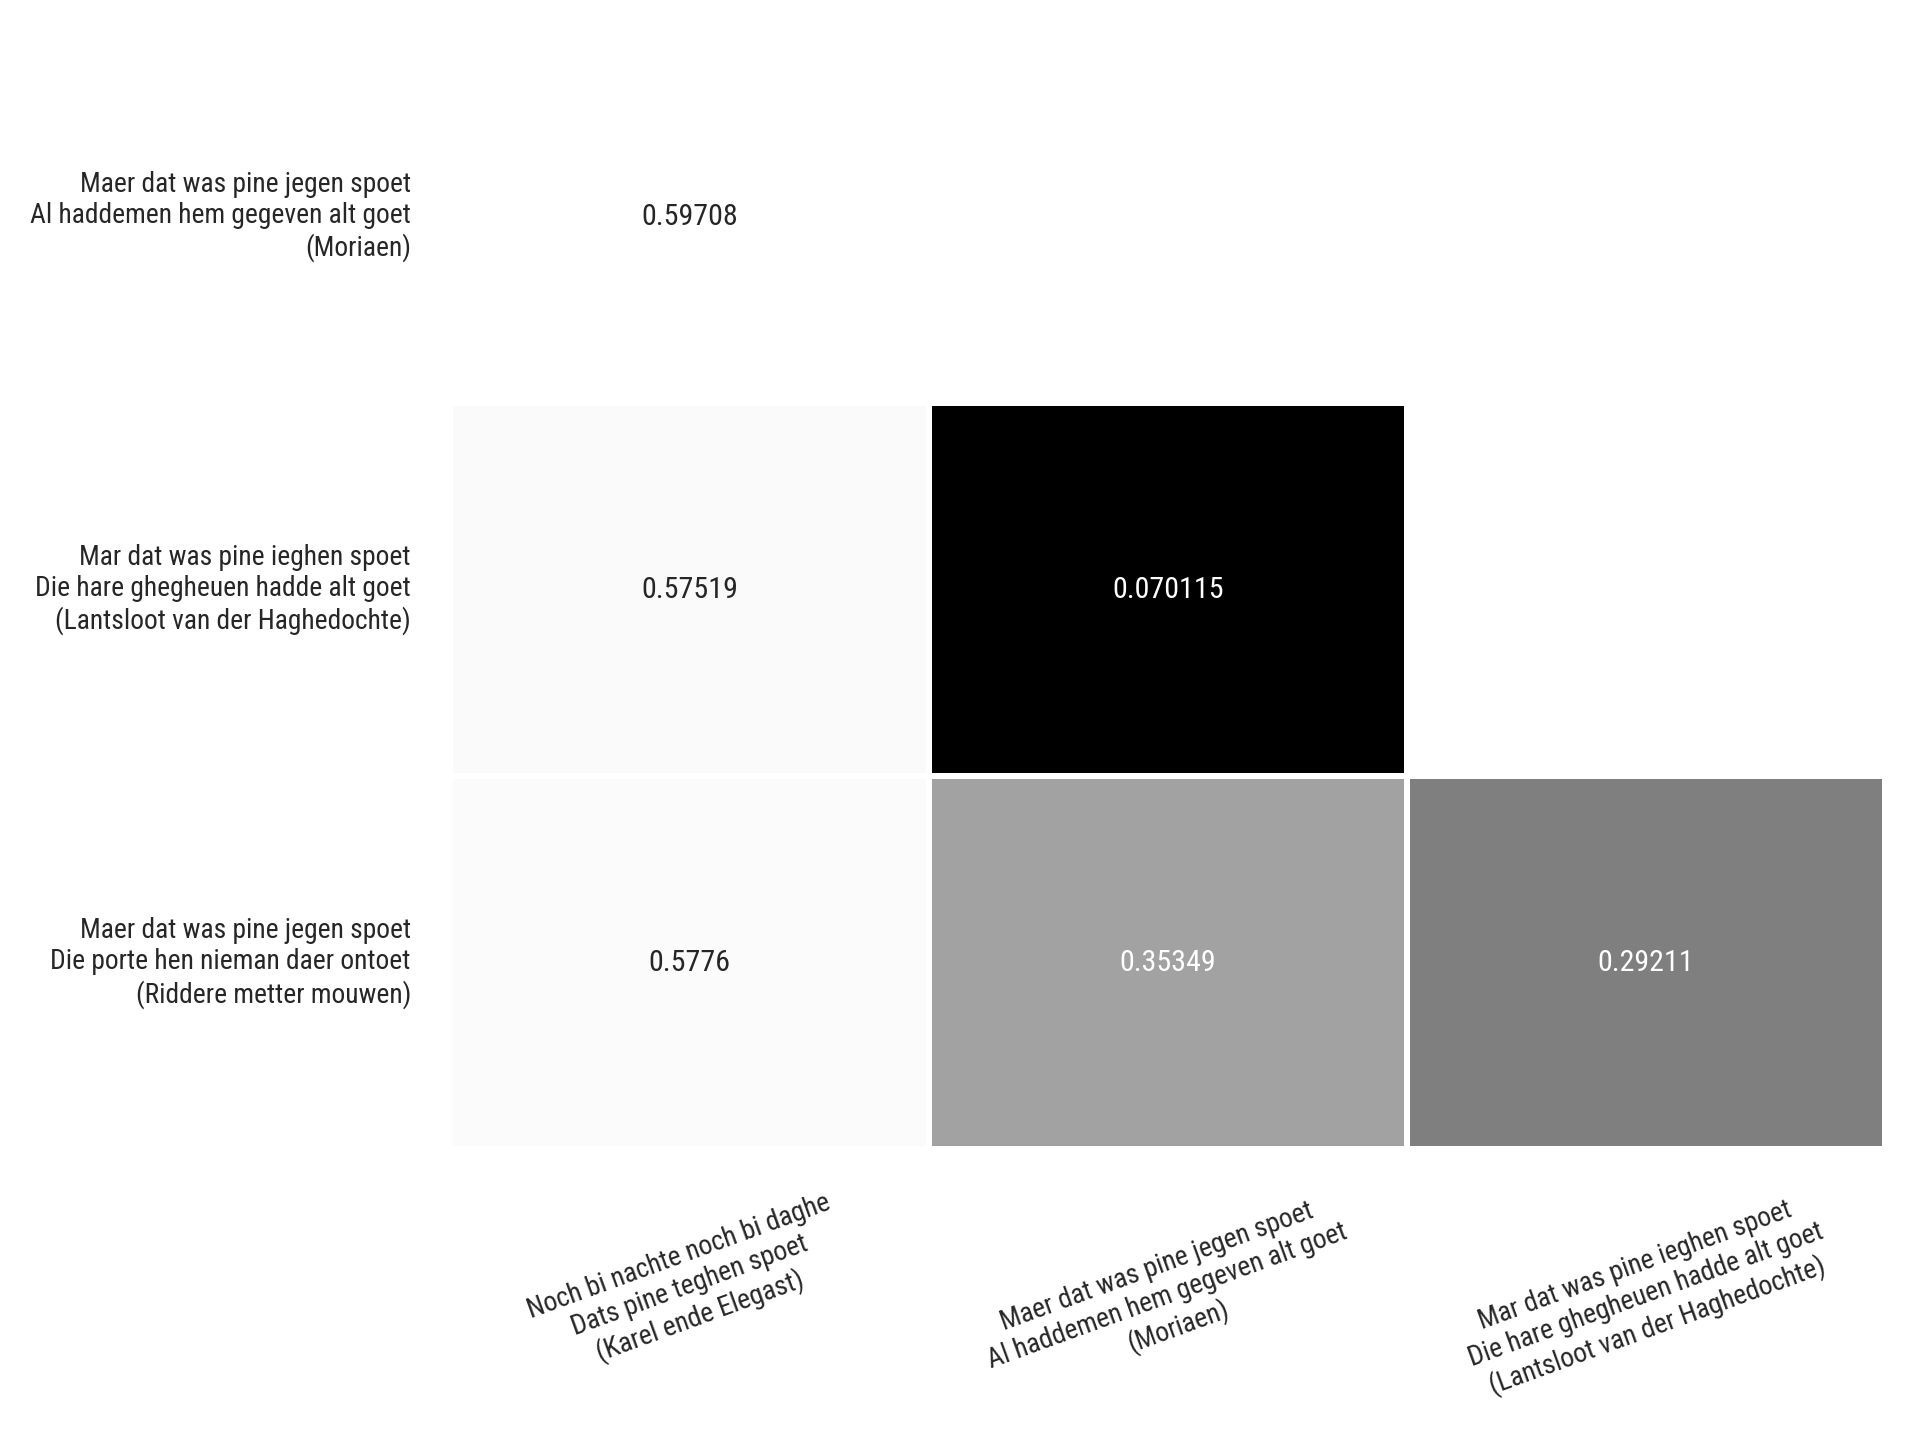

In [21]:
small_x = vec.transform(targets['lemmas']).toarray() + .15 * vec.transform(targets['rhyme']).toarray()
distances = squareform(pdist(small_x, metric='cosine'))
np.fill_diagonal(distances, np.nan)
distances[np.triu_indices(4)] = np.nan
labels = targets['tokens']
labels = [l.replace(' / ', '\n') for l in labels]
labels = [f'{label}\n({title})' for label, title in zip(labels, targets['title'])]
distances = pd.DataFrame(distances, index=labels, columns=labels)
distances = distances.iloc[1:, :-1]
ax = sb.heatmap(distances, annot=True, cmap='Greys_r', cbar=False,
                linewidths=1, linecolor='white', fmt='.5g')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f'{fig_dir}/Afb4.jpg', dpi=300);

In [22]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta.sample(5)

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
144,lan-ele-20,Lantsloot van der Haghedochte,Die was van hoghen gewerke Alst ware ene kerke:,Moriaen,Alse hoge alse ene kerke Ende van harden diren gewerke.,2,"Heeroma 1973b, Moriaen (II)",NaN
209,lan-ele-1,Lantsloot van der Haghedochte,Het was altoos sine zede:,Karel ende Elegast,Het was altoes sine seden.,1,"Heeroma 1973b, Moriaen (II)",NaN
100,mor-mou-19,Moriaen,. ende sine gewaden / Waren harde omberaden.,Riddere metter mouwen,.. ende haer gewaden : / Dus waren si alle omberaden.,2,Van der Stempel 1933,NaN
221,lan-ele-72,Lantsloot van der Haghedochte,Op waleweine die daer leet Ende die hem tandwordene vermeet:,Karel ende Elegast,Waer om dat hi aldus lijt Ende sijnre talen aldus vermijt.,2,"Heeroma 1973b, Moriaen (II)",NaN
176,lan-ele-44,Lantsloot van der Haghedochte,op dese ure Hi was ghewapint wel ter cure:,Moriaen,Ende wapine goet ter cure Si porden vte ter goder vre.,2,"Heeroma 1973b, Moriaen (II)",NaN


Determine rhyme weight with no restrictions on vocabulary size, except for `min_df=2`:

In [23]:
vec = TfidfVectorizer(max_features=None, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

In [24]:
def precision_recall(df, meta, vec, rhyme_weight=.15):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Max(F1)=0.3528 voor afstand < 0.5


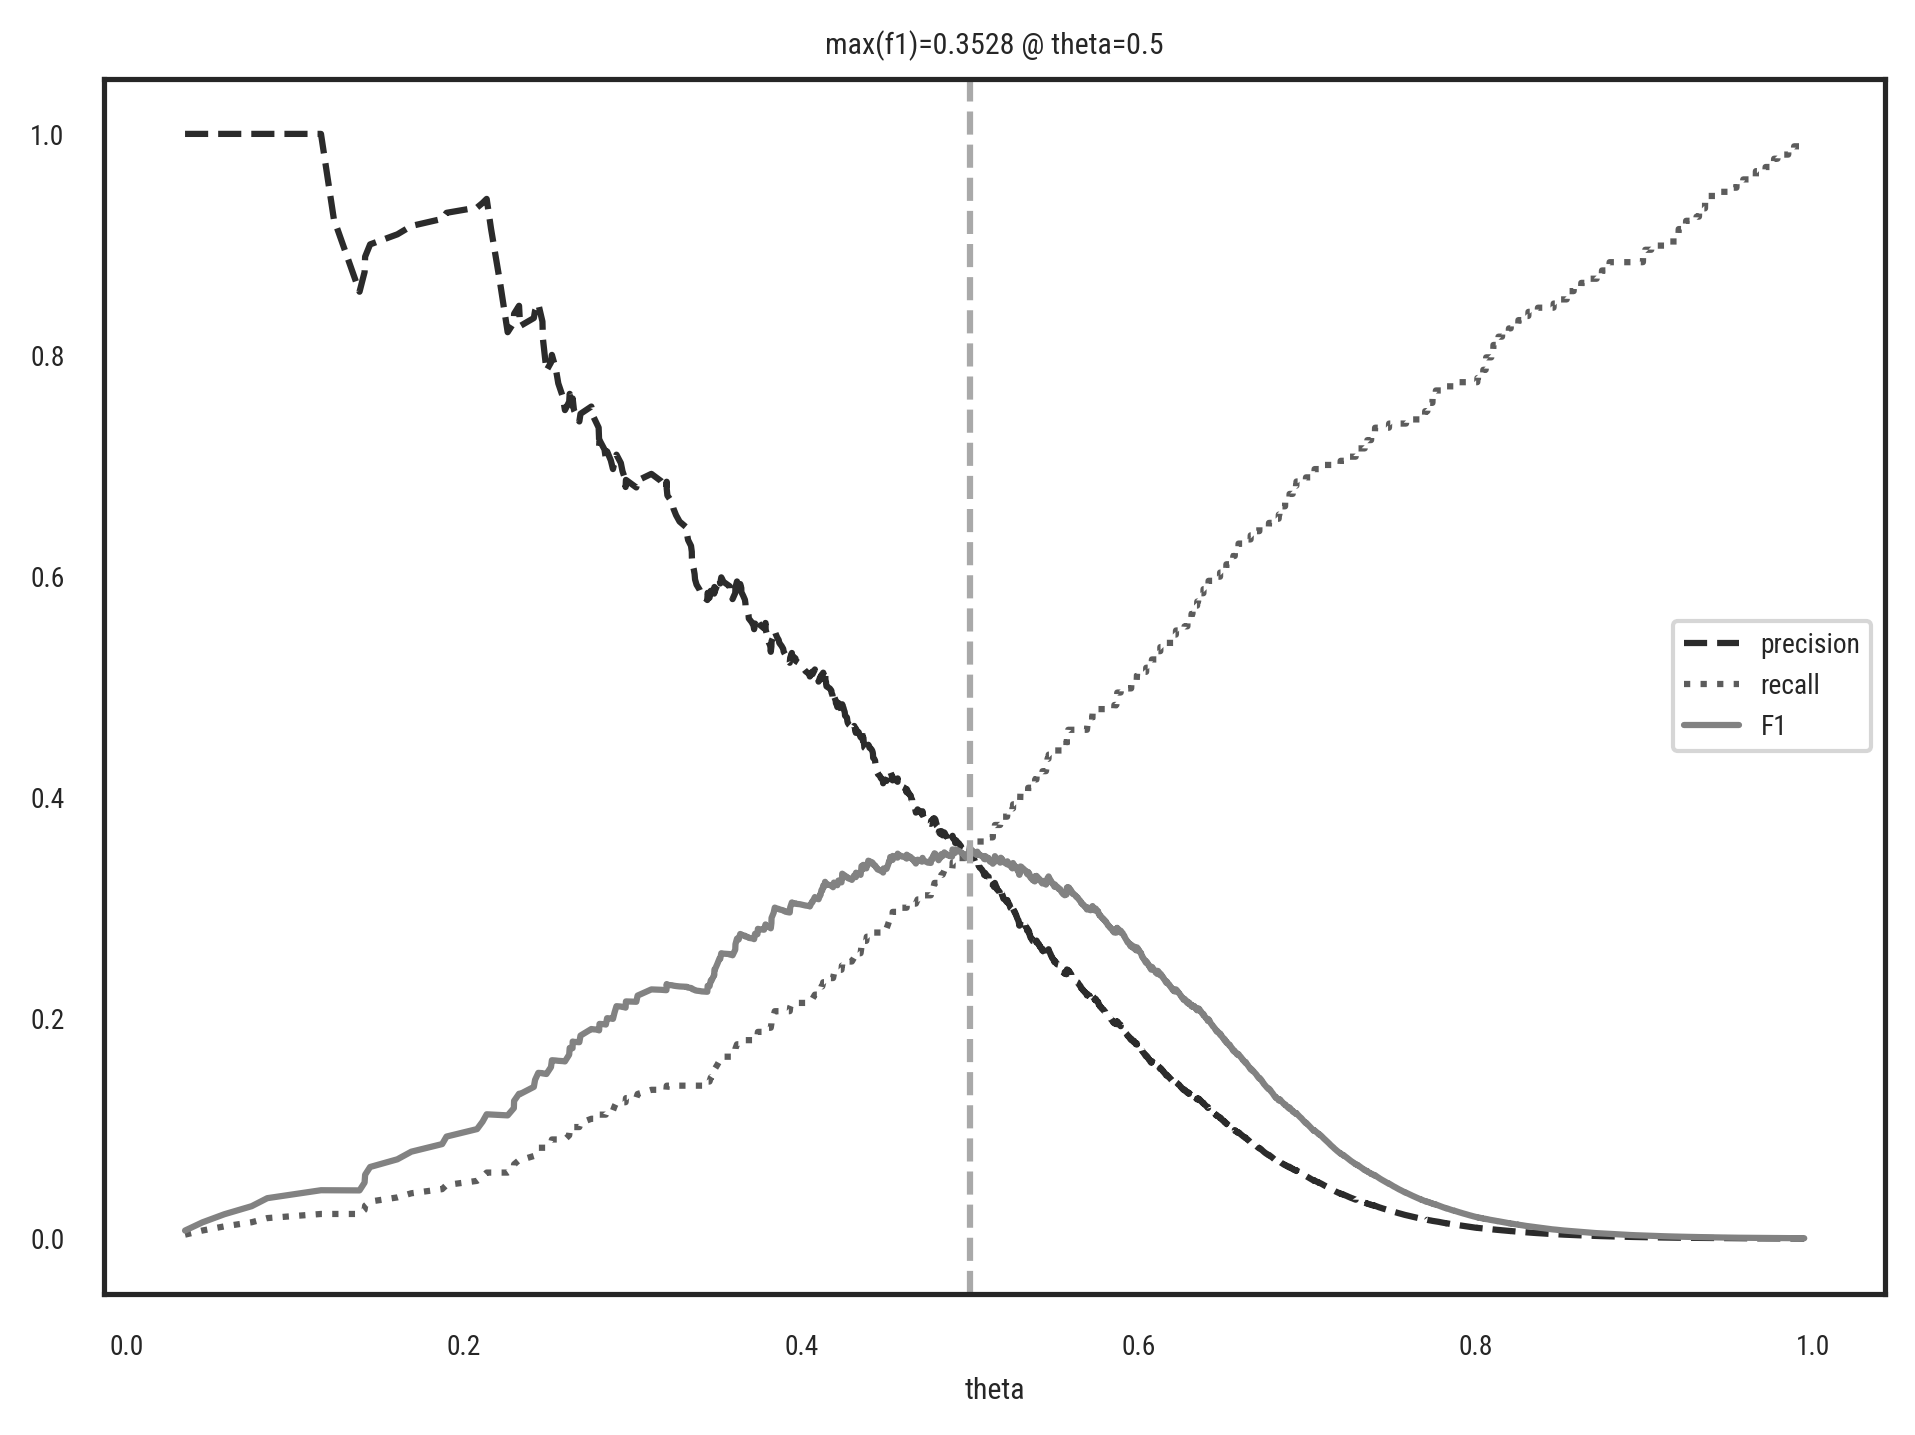

In [25]:
def precision_recall_curve_distances(y_true, distances):
    y_true = np.array(y_true)
    distances = np.array(distances)
    
    desc_score_indices = np.argsort(distances)
    y_true = y_true[desc_score_indices]
    distinct_value_indices = np.where(np.diff(distances[desc_score_indices]))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    # Accumulate true positives and false positives
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    precisions = tps / (tps + fps)
    recalls = tps / tps[-1]
    thresholds = distances[desc_score_indices][threshold_idxs]
    
    thresholds = thresholds[:-1]
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    
    return precisions, recalls, thresholds

precisions, recalls, thresholds = precision_recall_curve_distances(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)
max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]

print(f'Max(F1)={round(max_f1, 4)} voor afstand < {round(max_f1_th, 4)}')

plt.plot(thresholds, precisions, label='precision', ls='dashed')
plt.plot(thresholds, recalls, label='recall', ls='dotted')
plt.plot(thresholds, f1s, label='F1', ls='solid')
plt.axvline(max_f1_th, c='darkgrey', ls='--')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout();


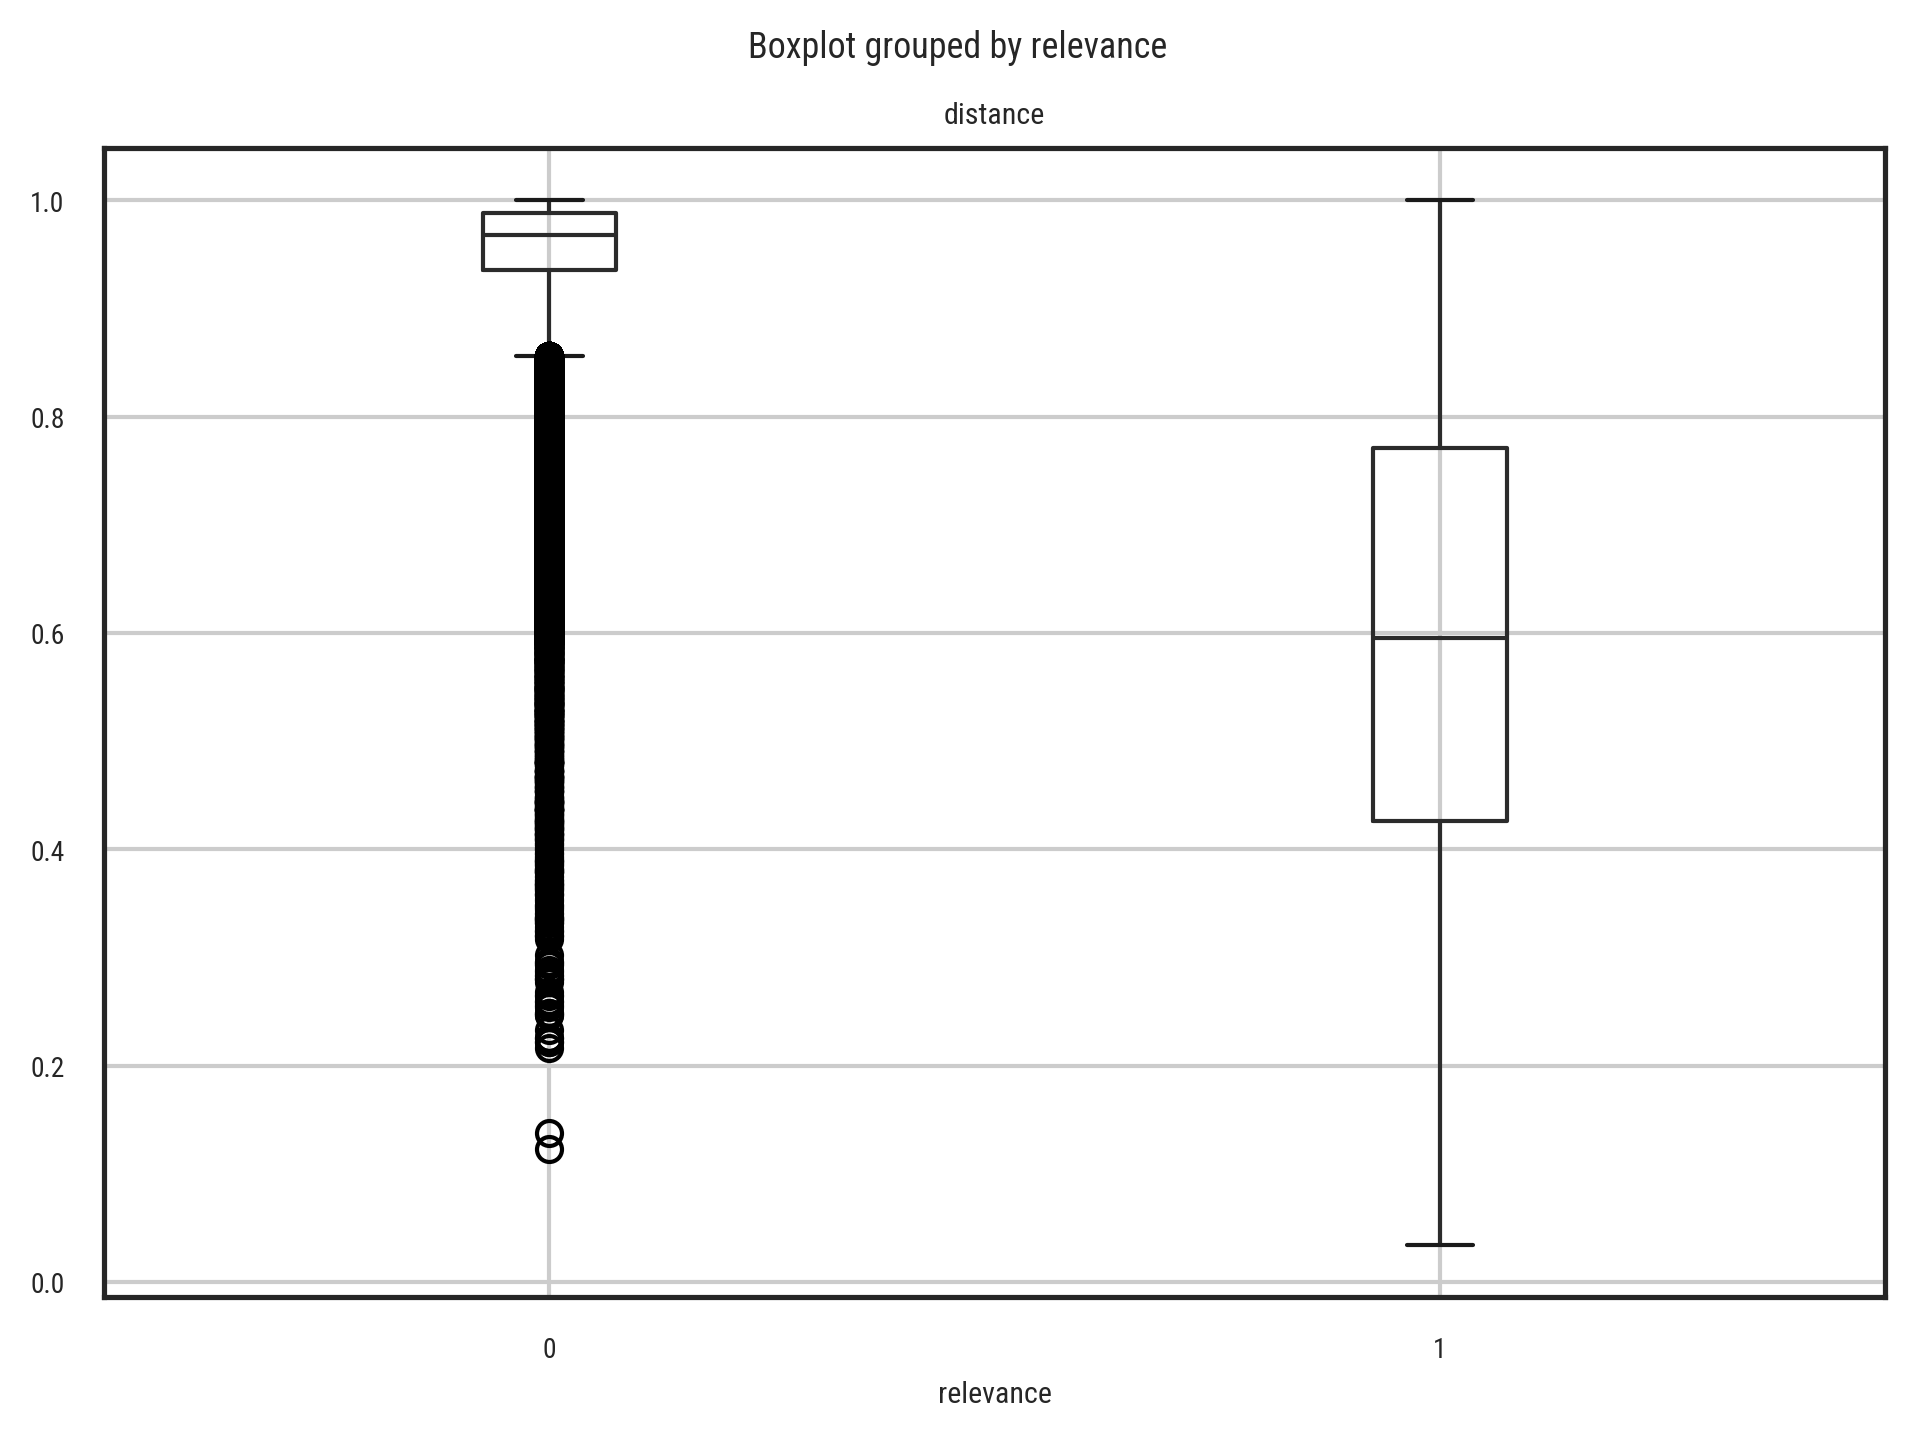

In [26]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

### Calibrate parameters

In this section, we have the code for experimenting with different hyperparameters of the system, so that we can calibrate it on the inventorized intertexts. We experimented with the:
- additional weight for lemmas in verse-final, rhyme position;
- the size of the vectorization vocabulary used;
- the effect of TF-IDF (vs plain TF, which takes the relative frequencies of the lemmas at face value).

##### 1. Rhyme weight

100%|██████████| 50/50 [02:28<00:00,  2.97s/it]


optimal rhyme weight: 0.1693877551020408


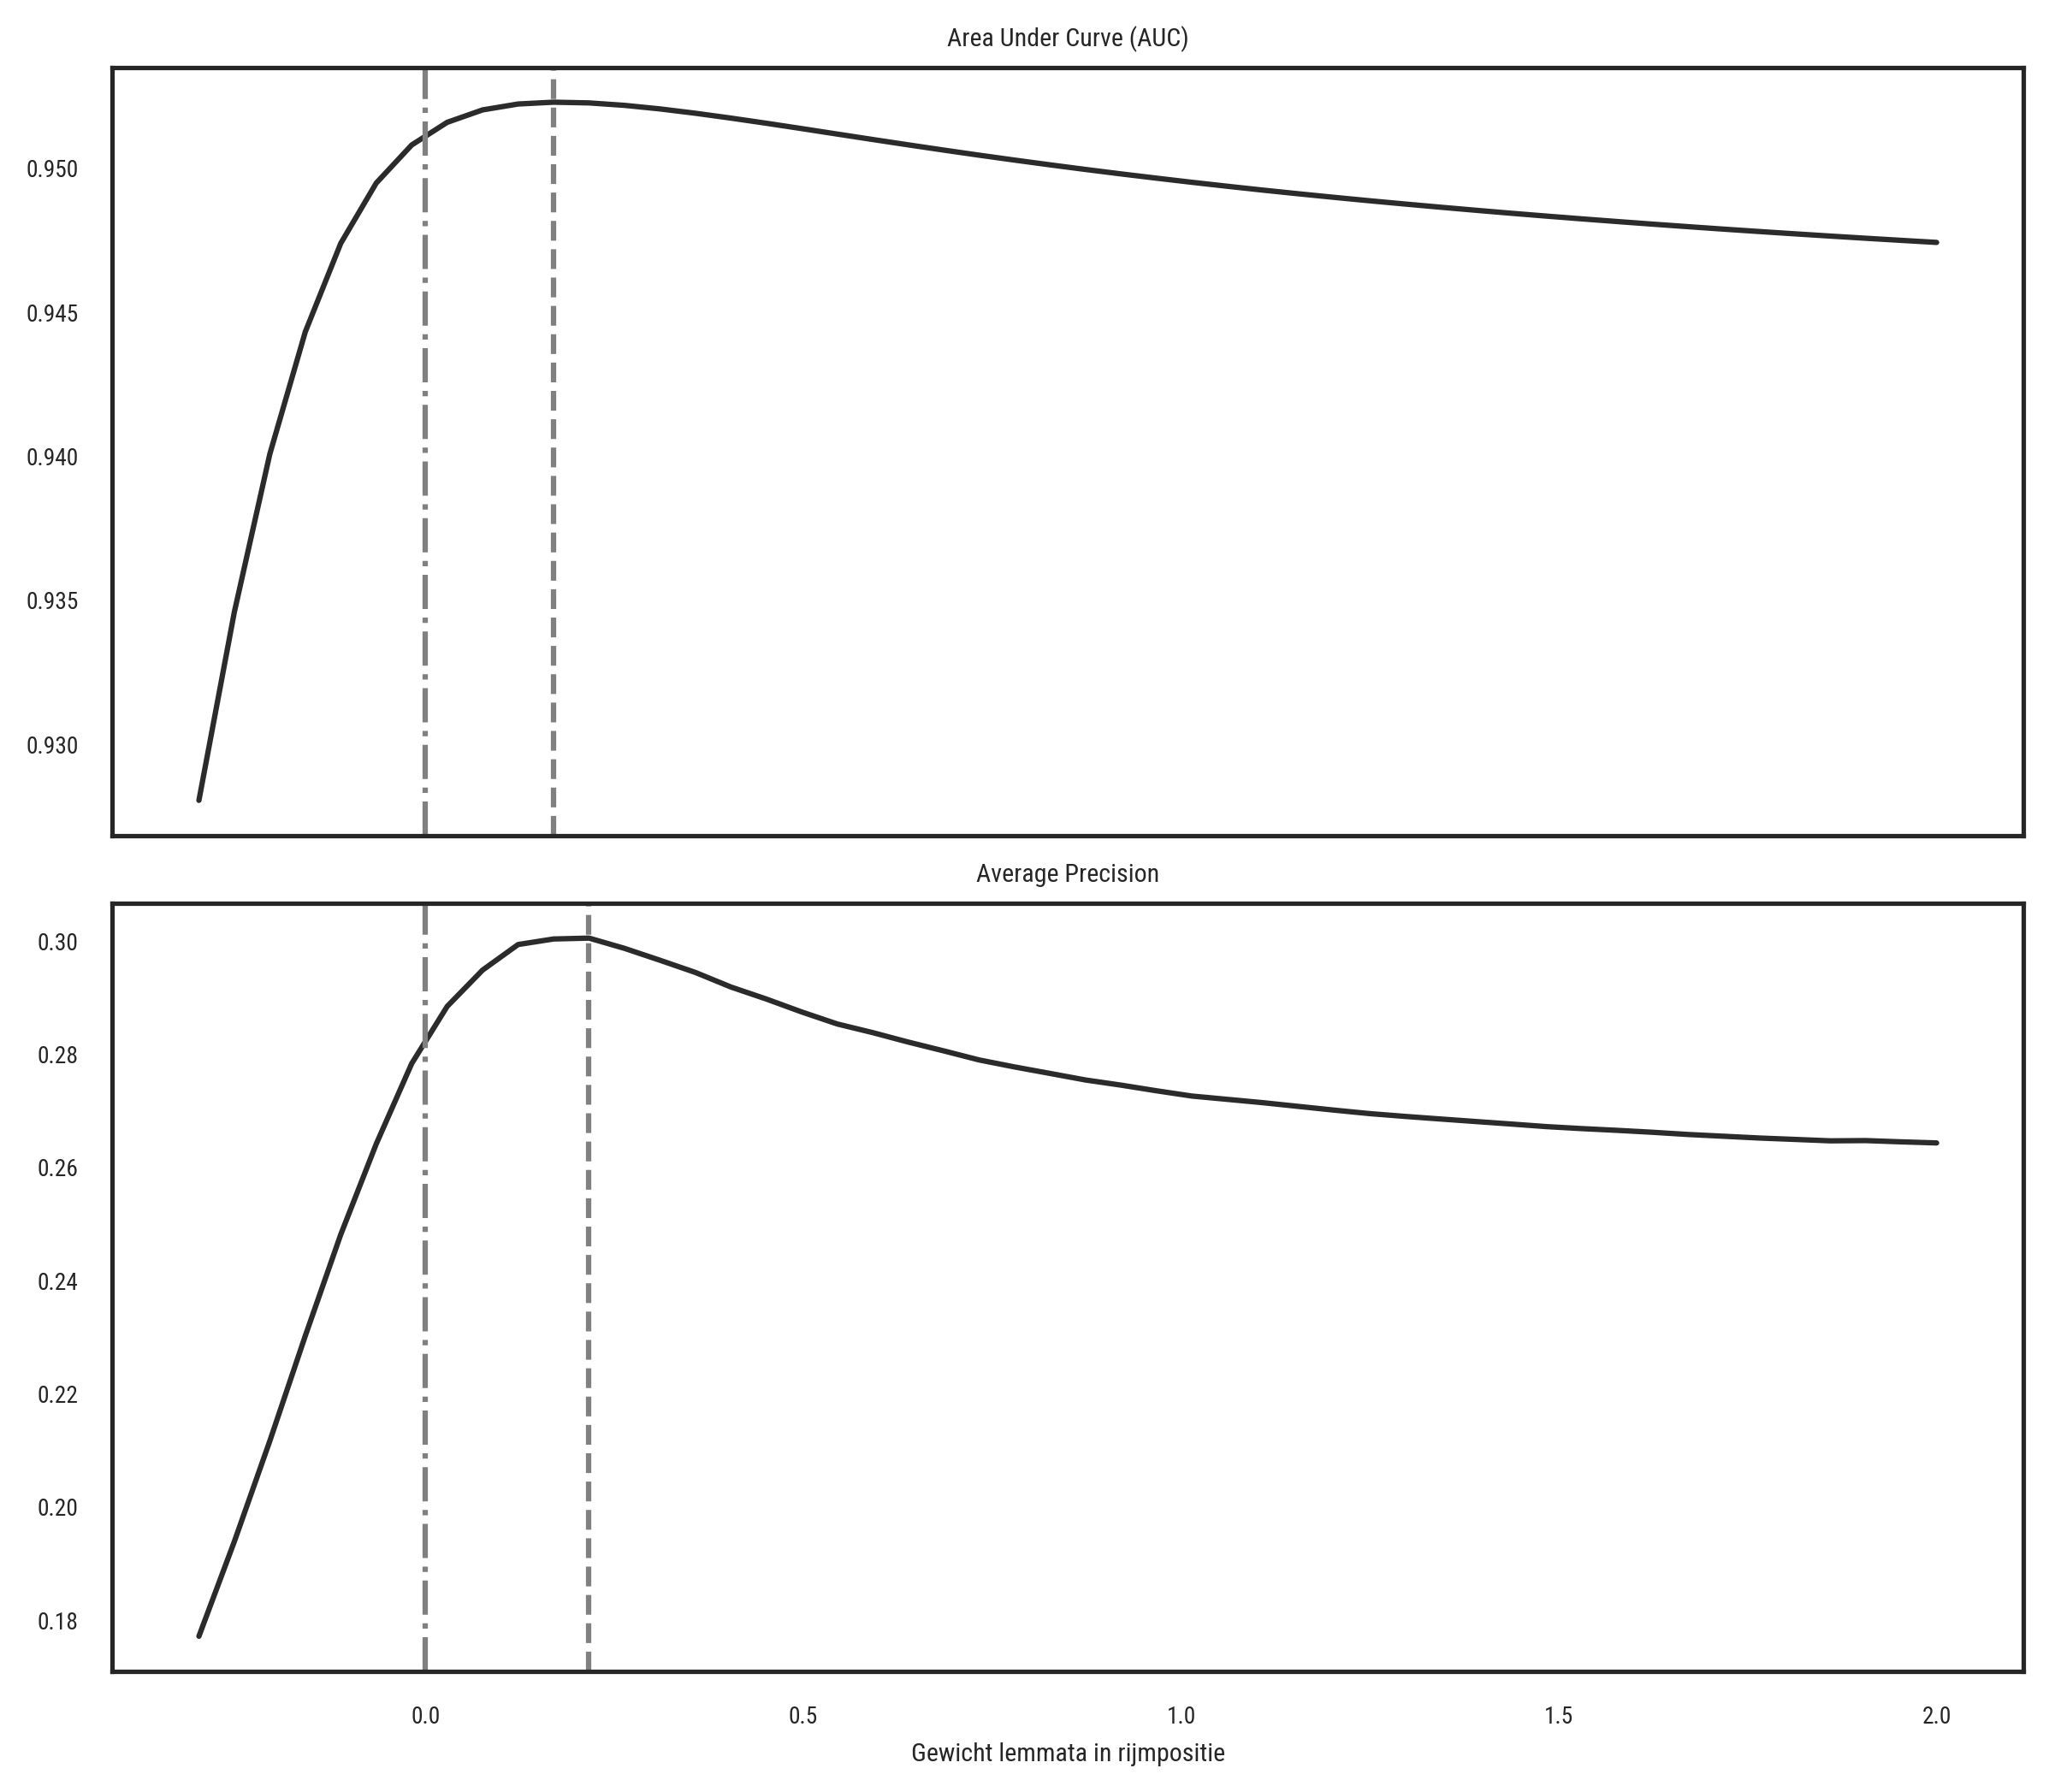

In [27]:
scores = []
# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances) # take complement of distances
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

# AUC plot
scores.plot('rhyme weight', 'AUC', ax=ax1, legend=False)
ax1.axvline(0, ls='-.', c='grey')
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
ax1.set_title('Area Under Curve (AUC)')

# Average Precision plot
scores.plot('rhyme weight', 'AV-PREC', ax=ax2, legend=False)
ax2.axvline(0, ls='-.', c='grey')
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey')
ax2.set_title('Average Precision')

plt.xlabel('Gewicht lemmata in rijmpositie')

plt.tight_layout()
plt.savefig(f'{fig_dir}/Afb5.jpg')

optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
print('optimal rhyme weight:', optim_rw)

##### 2. Vocabulary size (and TF vs TF-IDF)

In [28]:
vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None,
                      min_df=2, max_features=None).fit(df['lemmas'])
print('Maximum vocab size:', len(vec.get_feature_names_out()))

scores = []

vocab_sizes = list(range(500, 41000, 500))
parametrizations = {
                    'TF-IDF': {'min_df': 2},
                    'TF': {'use_idf': False, 'min_df': 2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))

Maximum vocab size: 40095


  9%|▊         | 7/81 [01:30<15:56, 12.93s/it]


KeyboardInterrupt: 

In [ ]:
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

# For AV-PREC plot
for i, (p, gr) in enumerate(scores.groupby('param')):
    linestyle = ':' if i == 0 else '-'  # dotted for first group, solid for others
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1, linestyle=linestyle)
ax1.set_title('AV-PREC')

# For AUC plot
for i, (p, gr) in enumerate(scores.groupby('param')):
    linestyle = ':' if i == 0 else '-'  # dotted for first group, solid for others
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2, linestyle=linestyle)
ax2.set_title('AUC')

plt.xlabel('Aantal lemmata in vocabularium')

plt.tight_layout()
plt.savefig(f'{fig_dir}/Afb6.jpg', dpi=300);


We use the product of the two scores, Area-Under-the-Curve (AUC) and average precision, to select the optimal vocabulary size:

In [ ]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']

## Final threshold

After optimizing the three parameter's in the previous section, we can now the optimal threshold value for determining (in a pragmatic, binary fashion) whether or not a combination of two verse groups might be an "intertext". To set this value, we vary the threshold between 0 and 1 and determine the distance where the trade-off betwene precision and recall is maximized, as reflected in the F1-score:

In [ ]:
vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
precisions, recalls, thresholds = precision_recall_curve_distances(relevances, distances)

f1s = (2 * precisions * recalls) / (precisions + recalls)
max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]

print(f'Max(F1)={round(max_f1, 4)} voor afstand < {round(max_f1_th, 4)}')

plt.plot(thresholds, precisions, label='precision', ls='dashed')
plt.plot(thresholds, recalls, label='recall', ls='dotted')
plt.plot(thresholds, f1s, label='F1', ls='solid')
plt.axvline(max_f1_th, c='darkgrey', ls='--')
plt.gca().set_xlabel('distance')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ distance={round(max_f1_th, 4)}')
plt.tight_layout()
plt.savefig(f'{fig_dir}/Afb7.jpg', dpi=300)

So, to sum up, according to the calibration, the following system parameters were found to be optimal:

In [ ]:
print('optim_vs =', optim_vs)
print('optim_rw =', optim_rw)
print('optim_th =', max_f1_th)

### Nearest neighbors

The code block below generates the table with the $n$ most similar verse groups between *Moriaen* and *Lantsloot*. This example was used for the qualitative inspection of the results of the calibrated system. Note that we ignore hits if one of the passages contained 2+ proper nouns, which typically yielded uninteresting results.

In [ ]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.15):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\\(prop\\)') < prop_filt) & \
                      (nearest['lemmas2'].str.count('n\\(prop\\)') < prop_filt) 
                     ]
    return nearest

nearest_df = nearest_verses('Moriaen', 'Lantsloot van der Haghedochte',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(30)

In [34]:
table_df = nearest_df.head(10)[['tokens1', 'tokens2', 'intertext1', 'intertext2', 'distance']]
table_df.columns = ['Moriaen', 'Lantsloot', 'intertext1', 'intertext2', 'distance']
table_df.to_excel('../figures/Tab4.xlsx')